In this notebook assess the selective ping export from wideband frequency response exportfrom a region. Default now (Echoview 12.1 is 10 evenly spaced pings)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import win32com.client as win32
import glob
import os

import sys
sys.path.insert(1, 'C:/Users/mbd/phd/ScatteringModels/')
import inverse_method_funs_med as inv

## Location of data files

In [31]:
# Location of data files
data_folder = 'F:/GLIDER2018/Echosounder/TromsøflaketEV/'

export_folder = 'F:/GLIDER2018/Echosounder/TromsøflaketEV/Widebandcheck/'

# Define variable name to export
var_name = ' Fileset 1: Sv pulse compressed wideband pings T1'

# Find all data files with extension .01A 
ev_file_names = glob.glob(data_folder + 'Widebandexportcheck*.EV')

In [32]:
ev_file_names

['F:/GLIDER2018/Echosounder/TromsøflaketEV\\Widebandexportcheck_GLIDER2018_20180625_PM.EV']

## Export Wideband frequency response for all regions in the file

In [17]:
# Loop through EV files, re-create them with the new template

window_length = 0.4
freq_res = 0.1 #kHz

for ind in range(len(ev_file_names)):
    
    # Connect to the Echoview application
    EvApp = win32.Dispatch("EchoviewCom.EvApplication") 

    # Open next EV file
    EvFile = EvApp.OpenFile(ev_file_names[ind])
    EvApp.Minimize()

    # Select correct variable
    Sv_pcVar = EvFile.Variables.FindByName(var_name)
    
    # How many regions in this fileset
    n_regions = EvFile.Regions.Count

    # Export wideband frequency response for each region.
    for ind_region in range(n_regions):
        EvSelectedRegion = EvFile.Regions.Item(ind_region)
        # Only export "analysis" regions not "badData"
        if EvSelectedRegion.RegionType == 1:
            fname = os.path.basename(ev_file_names[ind][:-3])
            Sv_pcVar.ExportSvWidebandFrequencyResponseForRegion(export_folder+fname+'_Widebandfrequencyexport_' + EvFile.Regions.Item(ind_region).Name +'.csv',
                                                            0, 0, window_length, 0, 1.0, EvSelectedRegion, freq_res)

    # Close file
    EvFile.Close()

    # Quit Echoview
    EvApp.Quit()

# Read wideband export from whole region (10pings)

In [144]:
fname_EV = glob.glob('F:/GLIDER2018/Echosounder/TromsøflaketEV/Widebandcheck/Whole.csv')

freqs_EV, sv_out_whole, times_whole = inv.read_widebandfrequencyresponse(fname_EV[0])
sv_median_whole = np.median(sv_out_whole,1)
q1_whole = np.percentile(sv_out_whole,25, axis=1)
q2_whole = np.percentile(sv_out_whole,75, axis=1)

# Read wideband export from all regions

In [134]:
fname_EV = glob.glob('F:/GLIDER2018/Echosounder/TromsøflaketEV/Widebandcheck/*_Widebandfrequencyexport*.csv')
nfiles = len(fname_EV)

sv_out_all = np.zeros([1001,0])
for ind in np.arange(nfiles):
    freqs_EV, sv_out, times_out = inv.read_widebandfrequencyresponse(fname_EV[ind])
    # Calculate the mean of the sv(f) across the SSL and optimize the density estimates based on the average.
    sv_out_all = np.append(sv_out_all, sv_out, axis=1)

sv_median_all = np.median(sv_out_all, axis=1)
q1_all = np.percentile(sv_out_all, 25, axis=1)
q2_all = np.percentile(sv_out_all ,75, axis=1)

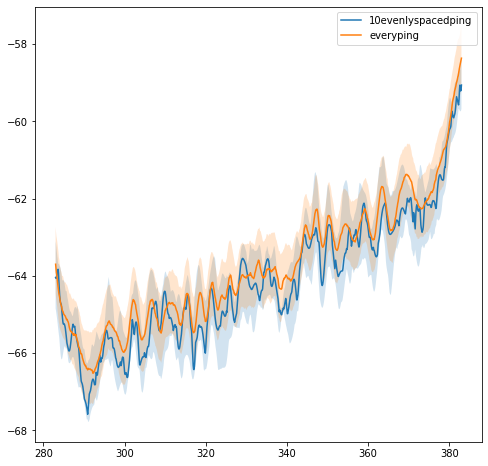

In [164]:
plt.figure(figsize=(8,8))
plt.plot(freqs_EV, 10*np.log10(sv_median_whole), label='10 evenly spaced ping')
plt.fill_between(freqs_EV, 10*np.log10(q1_whole),10*np.log10(q2_whole), alpha=0.2)
plt.plot(freqs_EV, 10*np.log10(sv_median_all), label='Every Ping')
plt.fill_between(freqs_EV, 10*np.log10(q1_all),10*np.log10(q2_all), alpha=0.2)
plt.legend()

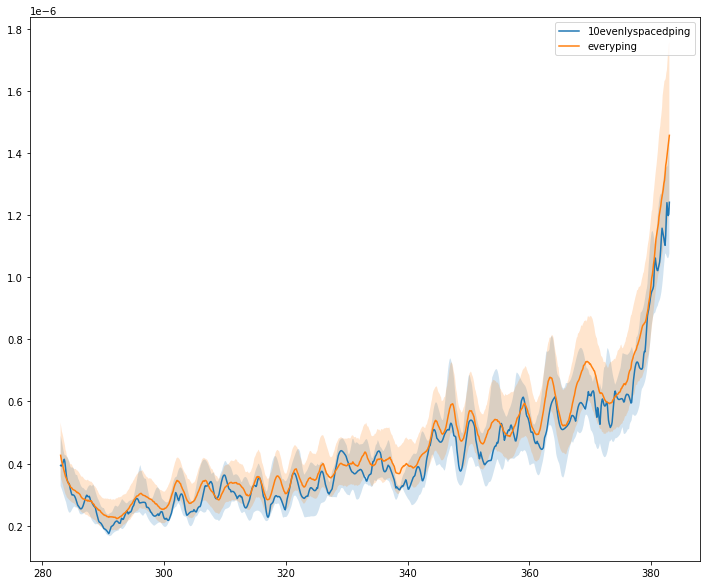

In [146]:
plt.figure(figsize=(12,10))
plt.plot(freqs_EV, sv_median_whole, label='10evenlyspacedping')
plt.fill_between(freqs_EV, q1_whole,q2_whole, alpha=0.2)
plt.plot(freqs_EV, sv_median_all, label='everyping')
plt.fill_between(freqs_EV, q1_all,q2_all, alpha=0.2)
plt.legend()

In [161]:
sv_diff = sv_median_all-sv_median_whole
difference = np.abs(np.diff(sv_diff,prepend=sv_diff[0]))

In [162]:
np.mean(difference/sv_median_all)

0.011994431978266419

In [154]:
np.std(difference)

5.423451437297838e-09